# Pymagicc Usage Examples

In [1]:
# NBVAL_IGNORE_OUTPUT
from pprint import pprint

import pymagicc
from pymagicc import MAGICC6
from pymagicc.io import MAGICCData
from pymagicc.scenarios import (
    rcp26, rcp45, rcps
)

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 9

## Scenarios

The four RCP scenarios are already preloaded in Pymagicc. They are loaded as `MAGICCData` objects with `metadata` attributes. `metadata` contains metadata

In [3]:
type(rcp26)

pymagicc.io.MAGICCData

In [4]:
pprint(rcp26.metadata)

{'description': 'HARMONISED, EXTENDED FINAL RCP3-PD (Peak&Decline) NOV26; '
                'RCP3PD-Contact: IMAGE group, Detlef van Vuuren '
                '(Detlef.vanVuuren@pbl.nl)',
 'header': 'Final RCP3PD with constant emissions after 2100 using the default '
           'RCPtool MAGICC6.3 settings. Compiled by: '
           'malte.meinshausen@pik-potsdam.de',
 'notes': 'DATE: 26/11/2009 11:29:06; MAGICC-VERSION: 6.3.09, 25 November 2009'}


`MAGICCData` subclasses OpenSCM's `ScmDataFrame` so we can access many of the dataframe's attributes directly, e.g.

In [5]:
rcp26.__class__.__bases__

(scmdata.dataframe.ScmDataFrame,)

In [6]:
rcp26.head()

time                                                                                                     2000-01-01 00:00:00  \
model scenario region        variable                                   unit         climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET                0.0000   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET                0.0000   
                             Emissions|CH4                              Mt CH4 / yr  unspecified   SET                0.4325   
                             Emissions|N2O                              Mt N2ON / yr unspecified   SET                0.0000   
                             Emissions|SOx                              Mt S / yr    unspecified   SET                5.5390   

time                                                                                                     2001-01-01 00:00:00  \
model scenario region        variable                                   unit         climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET                0.0000   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET                0.0000   
                             Emissions|CH4                              Mt CH4 / yr  unspecified   SET                0.4422   
                             Emissions|N2O                              Mt N2ON / yr unspecified   SET                0.0000   
                             Emissions|SOx                              Mt S / yr    unspecified   SET                5.5824   

time                                                                                                     2002-01-01 00:00:00  \
model scenario region        variable                                   unit         climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET                0.0000   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET                0.0000   
                             Emissions|CH4                              Mt CH4 / yr  unspecified   SET                0.4520   
                             Emissions|N2O                              Mt N2ON / yr unspecified   SET                0.0000   
                             Emissions|SOx                              Mt S / yr    unspecified   SET                5.6207   

time                                                                                                     2003-01-01 00:00:00  \
model scenario region        variable                                   unit         climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET                0.0000   
                             Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET                0.0000   
                             Emissions|CH4                              Mt CH4 / yr  unspecified   SET                0.4618   
                             Emissions|N2O                              Mt N2ON / yr unspecified   SET                0.0000   
                             Emissions|SOx                              Mt S / yr    unspecified   SET                5.6587   

time                                                                                                     2004-01-01 00:00:00  \
model scenario region        variable                                   unit         climate_model todo                        
IMAGE RCP26    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET                0.0000   
                            

The rcp's contain the following emissions with the following units

In [7]:
rcp26[["variable", "unit"]].drop_duplicates()

,variable,unit
0,Emissions|CO2|MAGICC Fossil and Industrial,Gt C / yr
1,Emissions|CO2|MAGICC AFOLU,Gt C / yr
2,Emissions|CH4,Mt CH4 / yr
3,Emissions|N2O,Mt N2ON / yr
4,Emissions|SOx,Mt S / yr
5,Emissions|CO,Mt CO / yr
6,Emissions|NMVOC,Mt NMVOC / yr
7,Emissions|NOx,Mt N / yr
8,Emissions|BC,Mt BC / yr
9,Emissions|OC,Mt OC / yr


The regions included are

In [8]:
rcp26["region"].unique()

array(['World|Bunkers', 'World|R5LAM', 'World|R5MAF', 'World|R5ASIA',
       'World|R5REF', 'World|R5OECD', 'World'], dtype=object)

A plot of four categories in RCP3PD

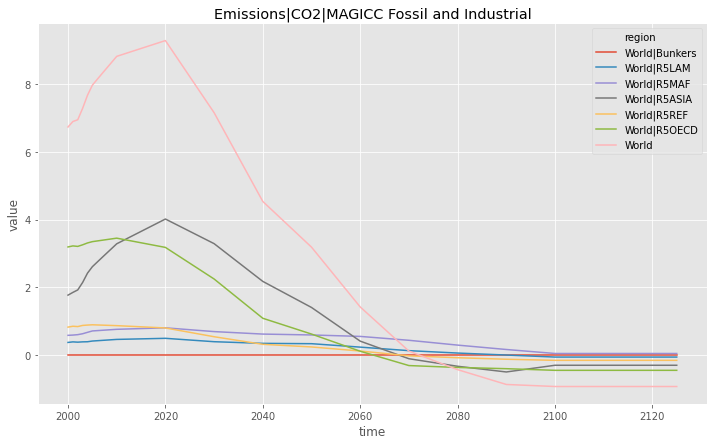

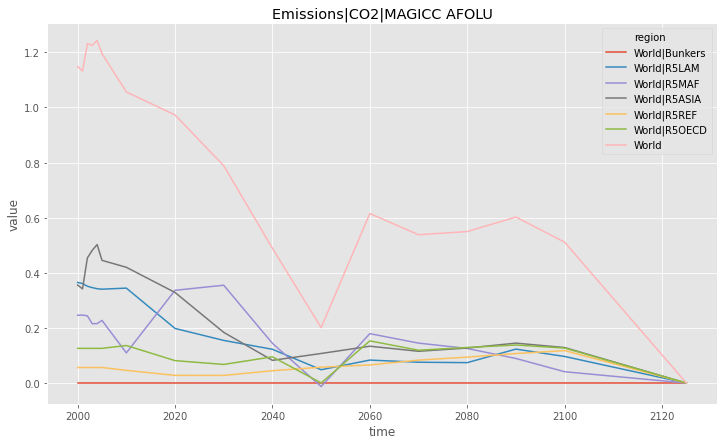

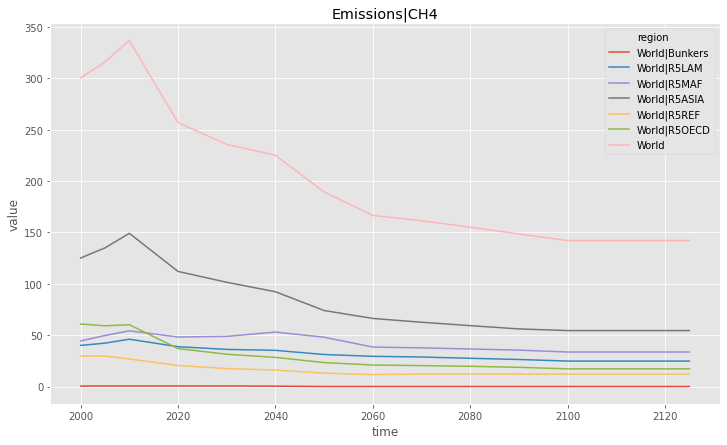

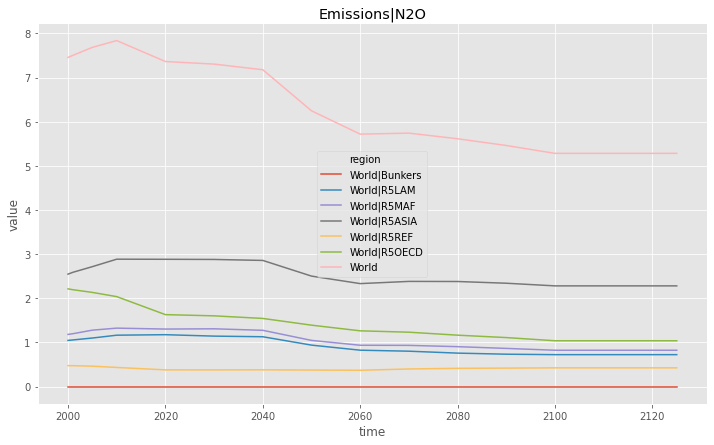

In [26]:
categories_to_plot = [
    "Emissions|" + v 
    for v in ["CO2|MAGICC Fossil and Industrial", "CO2|MAGICC AFOLU", "CH4", "N2O"]
]
for g in rcp26.filter(
    variable=categories_to_plot,
    year=range(1000, 2150)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="region").set_title(g.get_unique_meta("variable", True))

Fossil fuel emissions for the four RCP scenarios.

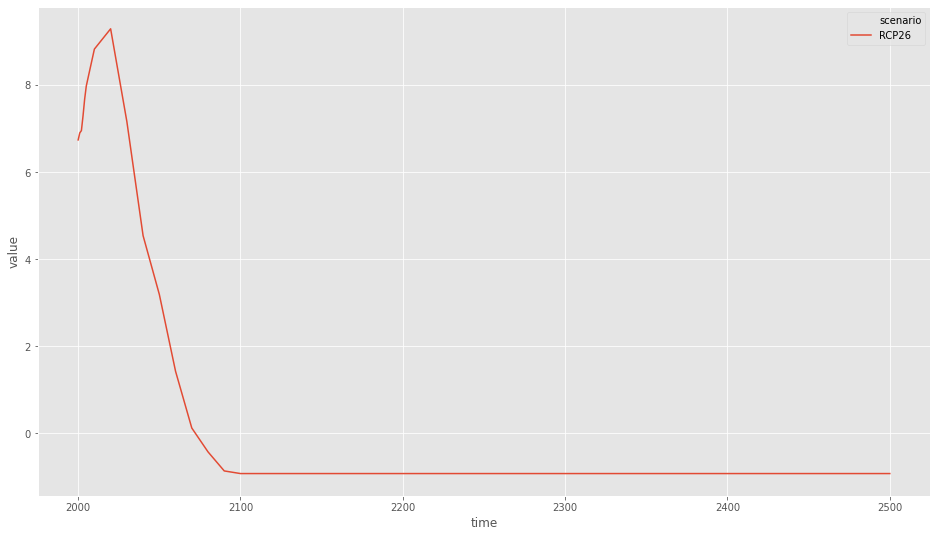

In [28]:
rcps.filter(
    variable="Emissions|CO2|MAGICC Fossil and Industrial",
    region="World"
).lineplot(x="time");

## Running MAGICC

A single `pymagicc` run takes under a second and returns the same object as used above. If not on Windows, the very first run might be slower due to setting up Wine. Multiple runs can be faster as setup times are reduced and other options speed things up even further e.g. limiting output to the subset of interest, using binary output formats.

In [11]:
# NBVAL_IGNORE_OUTPUT
%time results = pymagicc.run(rcp26)

CPU times: user 1.22 s, sys: 63.7 ms, total: 1.28 s
Wall time: 20.3 s


In [29]:
def multiple_runs():
    with MAGICC6() as magicc:
        for name, sdf in rcps.timeseries().groupby(["scenario"]):
            results = magicc.run(MAGICCData(sdf.copy()))

In [ ]:
# NBVAL_IGNORE_OUTPUT
%time multiple_runs()

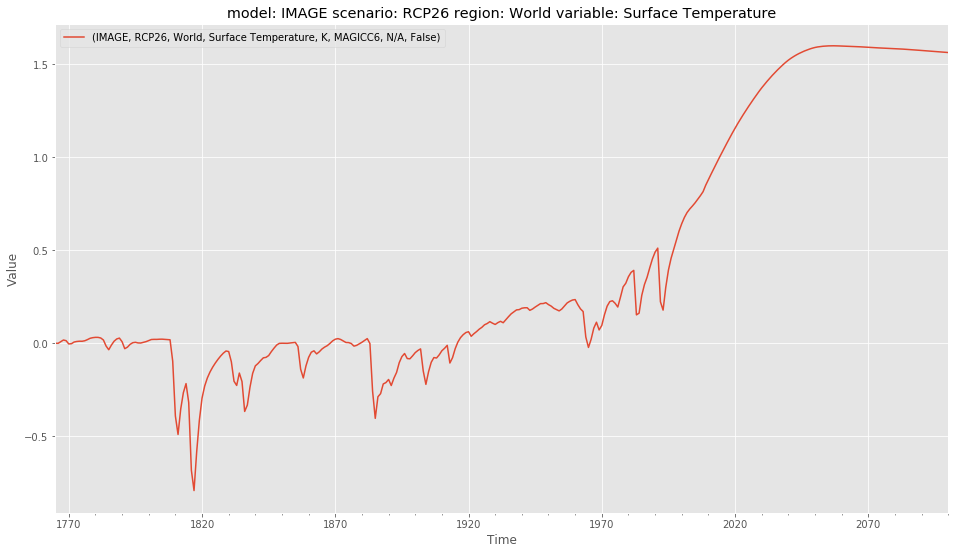

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
with MAGICC6() as magicc:
    for name, sdf in rcps.timeseries().groupby(["scenario"]):
        results = magicc.run(MAGICCData(sdf.copy()))
        results.filter(
            variable="Surface Temperature",
            region="World"
        ).lineplot(ax=ax, x="time");

The default parameters are the ones that were used to produce the RCP GHG concentrations (see also http://live.magicc.org/). Of course it's easy to change them.

In [15]:
low = pymagicc.run(rcp45, core_climatesensitivity=1.5)
default = pymagicc.run(rcp45, core_climatesensitivity=3)
high = pymagicc.run(rcp45, core_climatesensitivity=4.5)

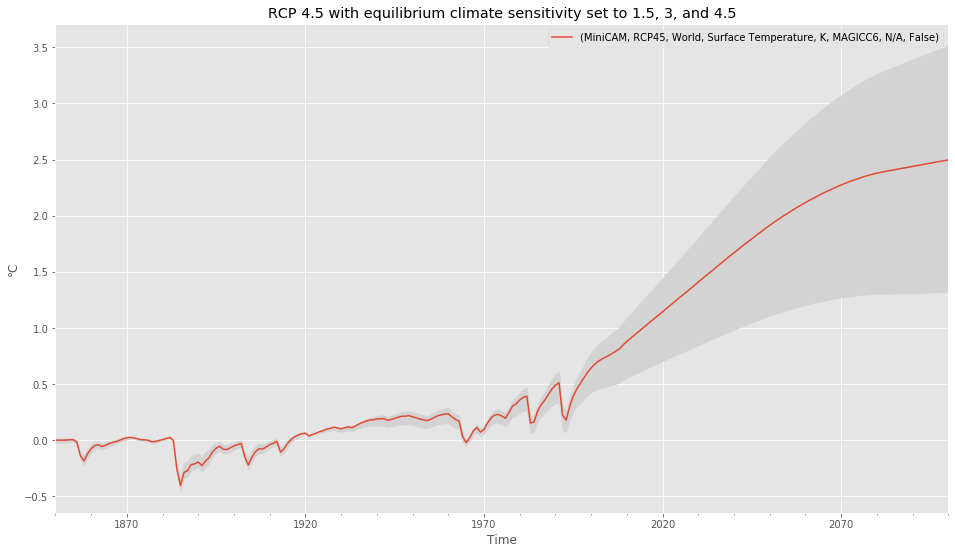

In [16]:
filtering = {
    "variable": "Surface Temperature",
    "region": "World",
    "year": range(1850, 2101),
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
default.filter(**filtering).line_plot(x="time", ax=ax)
plt.fill_between(
    low.filter(**filtering)["time"].values,
    low.filter(**filtering).timeseries().values.squeeze(),
    high.filter(**filtering).timeseries().values.squeeze(),
    color="lightgray"
)

plt.title(
    "RCP 4.5 with equilibrium climate sensitivity set to 1.5, 3, and 4.5"
)
plt.ylabel("°C");